<a href="https://colab.research.google.com/github/Agrave1/NFL_Scores/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
betting_df = pd.read_csv("/content/drive/MyDrive/Project 2/Spread_Scores.csv")
betting_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,total_score,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,37,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,52,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,34,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14.0,19.0,33,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24.0,3.0,27,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN


## Data Cleaning

In [3]:
betting_df.duplicated().sum()

0

In [4]:
betting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13232 entries, 0 to 13231
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        13232 non-null  object 
 1   schedule_season      13232 non-null  int64  
 2   schedule_week        13232 non-null  object 
 3   schedule_playoff     13232 non-null  bool   
 4   team_home            13232 non-null  object 
 5   score_home           13231 non-null  float64
 6   score_away           13231 non-null  float64
 7   total_score          13232 non-null  int64  
 8   team_away            13232 non-null  object 
 9   team_favorite_id     10753 non-null  object 
 10  spread_favorite      10753 non-null  float64
 11  over_under_line      10743 non-null  object 
 12  stadium              13232 non-null  object 
 13  stadium_neutral      13232 non-null  bool   
 14  weather_temperature  12189 non-null  float64
 15  weather_wind_mph     12172 non-null 

In [5]:
betting_df = betting_df.drop(labels = range(0, 2500), axis = 0)
#Dropped those rows because all the missing values were at the start of the dataset
#Didn't impute because these betting statistics can't be imputed or they would skew the results for the games with accurate betting data

In [6]:
betting_df["schedule_week"].replace({"SuperBowl" : "Superbowl", "WildCard" : "Wildcard"}, inplace = True)
betting_df["schedule_week"].value_counts()
#Fixed inconsistencies in the naming of object data

16            649
15            649
1             647
2             647
13            645
14            644
12            641
11            625
3             598
10            589
9             572
4             572
7             569
8             567
5             560
6             557
17            509
Division      172
Wildcard      160
Conference     86
Superbowl      44
18             30
Name: schedule_week, dtype: int64

In [7]:
betting_df["score_home"].fillna(23, inplace = True)
betting_df["score_away"].fillna(20, inplace = True)
#Filled in missing values for Superbowl 2021 season with correct score after google searching

In [8]:
betting_df = betting_df.drop(columns = ["weather_detail"])
#Too many categorical values and too many missing values to input based on most frequent
#Most frequent was dome and many stadiums and games would be incorrectly classified as dome if imputed

In [9]:
betting_df.isna().sum()

schedule_date             0
schedule_season           0
schedule_week             0
schedule_playoff          0
team_home                 0
score_home                0
score_away                0
total_score               0
team_away                 0
team_favorite_id          0
spread_favorite           0
over_under_line           0
stadium                   0
stadium_neutral           0
weather_temperature     813
weather_wind_mph        830
weather_humidity       4400
dtype: int64

# Preprocessing

In [10]:
betting_df["schedule_week"].value_counts()
betting_df.replace({"Wildcard" : 19, "Division" : 20, "Conference" : 21, "Superbowl" : 22}, inplace = True)
betting_df["schedule_week"] = betting_df["schedule_week"].astype(int)
betting_df["schedule_week"].value_counts()

16    649
15    649
1     647
2     647
13    645
14    644
12    641
11    625
3     598
10    589
9     572
4     572
7     569
8     567
5     560
6     557
17    509
20    172
19    160
21     86
22     44
18     30
Name: schedule_week, dtype: int64

In [11]:
betting_df["schedule_playoff"].value_counts()
betting_df["schedule_playoff"].replace({False : 0, True : 1}, inplace = True)
betting_df["schedule_playoff"].value_counts()

0    10270
1      462
Name: schedule_playoff, dtype: int64

In [12]:
betting_df["stadium_neutral"].value_counts()
betting_df["stadium_neutral"].replace({False : 0, True : 1}, inplace = True)
betting_df["stadium_neutral"].value_counts()

0    10642
1       90
Name: stadium_neutral, dtype: int64

In [13]:
betting_df2 = betting_df.copy()

In [14]:
X = betting_df2.drop(columns = ["total_score", "schedule_date", "score_home", "score_away"])
y = betting_df2["total_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [15]:
num_selector = make_column_selector(dtype_include = "number")
cat_selector = make_column_selector(dtype_include = "object")

In [16]:
median_imputer = SimpleImputer(strategy = "median")
freq_imputer = SimpleImputer(strategy = "most_frequent")
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown = "ignore", sparse = False)

In [17]:
num_pipe = make_pipeline(median_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

In [18]:
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)
preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fbeb7d08d90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object a

In [19]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fbeb7d08d90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object a

In [20]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_processed

array([[ 0.16479826, -0.66724938, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24626621, -0.66724938, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.63122137, -1.04284839, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.08333031, -1.41844741, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       [-1.46456075, -1.41844741, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.65360596, -1.41844741, -0.21225747, ...,  0.        ,
         0.        ,  0.        ]])

# Machine Learning Models

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [23]:
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

In [24]:
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

In [25]:
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(f"Training Accuracy: {train_score:.3f}")
print(f"Testing Accuracy: {test_score:.3f}")

Training Accuracy: 1.000
Testing Accuracy: -0.895


In [26]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [27]:
param_grid = {"max_depth" : [1, 2, 3], "min_samples_leaf" : [3, 15, 20], "min_samples_split" : [2, 20, 200]}

In [31]:
dt_grid_search = GridSearchCV(dec_tree, param_grid)
dt_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [1, 2, 3],
                         'min_samples_leaf': [3, 15, 20],
                         'min_samples_split': [2, 20, 200]})

In [32]:
dt_grid_search.best_params_

{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 200}

In [51]:
param_grid2 = {"max_depth" : [3, 5, 7], "min_samples_leaf" : [1, 2, 3], "min_samples_split" : [400, 500, 600]}

In [52]:
dt_grid_search2 = GridSearchCV(dec_tree, param_grid2)
dt_grid_search2.fit(X_train_processed, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [400, 500, 600]})

In [53]:
dt_grid_search2.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 500}

In [55]:
#retrieve the best version of the model
best_model = dt_grid_search2.best_estimator_
 
#refit the model on the whole training set
best_model.fit(X_train_processed, y_train)
#score the model on the test set
best_model.score(X_test_processed, y_test)


0.03623761625499666

In [ ]:
depths = list(range(2, 15))
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_processed, y_train)
    train_score = dec_tree.score(X_train_processed, y_train)
    test_score = dec_tree.score(X_test_processed, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

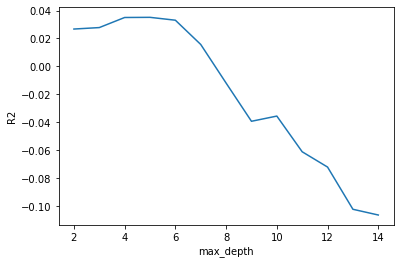

In [ ]:
import matplotlib.pyplot as plt
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

In [ ]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.035152,0.052999
4,0.035042,0.041612
6,0.033094,0.065965
3,0.02782,0.033393
2,0.02677,0.025568


In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
bagreg = BaggingRegressor(random_state = 42)
bagreg.fit(X_train_processed, y_train)

BaggingRegressor(random_state=42)

In [ ]:
bagreg_train_score = bagreg.score(X_train_processed, y_train)
bagreg_test_score = bagreg.score(X_test_processed, y_test)
print(f"Training Accuracy: {bagreg_train_score:.3f}")
print(f"Testing Accuracy: {bagreg_test_score:.3f}")

Training Accuracy: 0.817
Testing Accuracy: -0.064


In [ ]:
estimators = [10, 20, 30, 40, 50, 100]
scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train_processed, y_train)
   train_score = bag_reg.score(X_train_processed, y_train)
   test_score = bag_reg.score(X_test_processed, y_test)
   scores.loc[num_estimators, 'Train Score'] = train_score
   scores.loc[num_estimators, 'Test Score'] = test_score

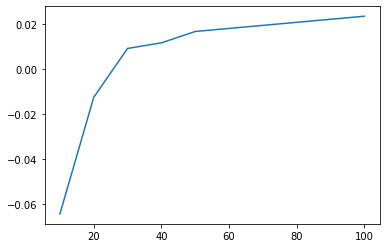

In [ ]:
plt.plot(scores['Test Score'])
plt.show()

In [ ]:
scores = scores.sort_values(by='Test Score', ascending=False)
scores

,Train Score,Test Score
100,0.865411,0.023569
50,0.85986,0.016809
40,0.85764,0.01176
30,0.852408,0.009273
20,0.843303,-0.012426
10,0.817253,-0.064203


# Feature Engineering

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [ ]:
scaled_df = scaler.fit_transform(X_train_processed)
pca = PCA()
pca.fit(scaled_df)

PCA()

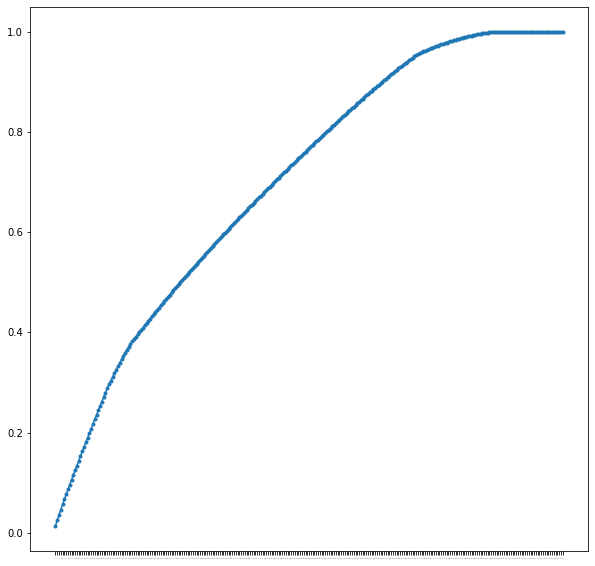

In [ ]:
fig, axes = plt.subplots(figsize = (10, 10))
plt.plot(range(1, 286), pca.explained_variance_ratio_.cumsum(), marker = '.')
plt.xticks(ticks=range(1, 286), fontsize = 1);

In [ ]:
pca_transformer = make_pipeline(scaler, PCA(n_components = .95))
#Chose .95 because 95% of the variance is explained and looking at the graph excludes many points that are relatively
#insignificant in increasing the overall variance

In [ ]:
linreg = LinearRegression()
linreg_pipe = make_pipeline(pca_transformer, linreg)
linreg_pipe.fit(X_train_processed, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=0.95))])),
                ('linearregression', LinearRegression())])

In [ ]:
train_pred_lin = linreg_pipe.predict(X_train_processed)
test_pred_lin = linreg_pipe.predict(X_test_processed)

In [ ]:
train_mae = mean_absolute_error(y_train, train_pred_lin)
test_mae = mean_absolute_error(y_test, test_pred_lin)
print(f"Model Training MAE: {train_mae:.3f}")
print(f"Model Testing MAE: {test_mae:.3f}")

Model Training MAE: 10.842
Model Testing MAE: 11.064


In [ ]:
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print(f"Model Training RMSE: {train_rmse:.3f}")
print(f"Model Testing RMSE: {test_rmse:.3f}")

Model Training RMSE: 0.000
Model Testing RMSE: 19.461


In [ ]:
print(f"Training Accuracy: {linreg_pipe.score(X_train_processed, y_train):.3f}")
print(f"Testing Accuracy: {linreg_pipe.score(X_test_processed, y_test):.3f}")

Training Accuracy: 0.101
Testing Accuracy: 0.034


The production model I will choose is the bagged regressor. It has a higher train score and the test score is comparable to the other models.